## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import os
import requests 
import pandas as pd

### Datos
Utilizo como dataset el epub de Drácula

In [2]:
# Funcion auxiliar para descargar el dataset
def download_dataset(dataset_url: str, target_filename: str, force: bool = False):
    if os.path.exists(target_filename) and not force:
        print("Dataset folder already exists, nothing downloaded.")
        return

    os.makedirs(os.path.dirname(target_filename), exist_ok=True)
    try:
        with requests.get(dataset_url, stream=True) as response:
            response.raise_for_status()  # Raise an exception for bad status codes

            with open(target_filename, 'wb') as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
        print(f"File '{target_filename}' downloaded successfully.")
    except requests.exceptions.RequestException as e:
        raise(Exception(f"Error downloading file: {e}"))

In [3]:
# Descargar el dataset
dataset = "datasets/dracula.txt"
download_dataset("https://www.gutenberg.org/cache/epub/345/pg345.txt", dataset)

Dataset folder already exists, nothing downloaded.


In [4]:
# Leo todas las líneas del archivo
df = pd.read_csv(dataset, sep='/n', header=None, engine="python")
df.head()

article_text = ''

#  Concateno todas las líneas en un solo string, en minúsculas
for _, row in df[:None].iterrows():
    article_text += row[0].lower() + ' '

print(f"Length of article text: {len(article_text)} characters")

Length of article text: 860387 characters


In [5]:
# Recorto el texto para que sea mas manejable
article_text = article_text.split("*** START OF THE PROJECT GUTENBERG EBOOK DRACULA ***".lower())[1]
article_text = article_text.split("*** END OF THE PROJECT GUTENBERG EBOOK DRACULA ***".lower())[0]
# Quito espacios extras
article_text = " ".join(article_text.split())
# Me quedo solo con la mitad del texto
article_text = article_text[:len(article_text)//2]
print(f"Length of article text: {len(article_text)} characters")

Length of article text: 419172 characters


In [6]:
# en article text se encuentra el texto del libro
article_text[15000:16000]

'en able to throw them off so easily. before us lay a green sloping land full of forests and woods, with here and there steep hills, crowned with clumps of trees or with farmhouses, the blank gable end to the road. there was everywhere a bewildering mass of fruit blossom--apple, plum, pear, cherry; and as we drove by i could see the green grass under the trees spangled with the fallen petals. in and out amongst these green hills of what they call here the “mittel land” ran the road, losing itself as it swept round the grassy curve, or was shut out by the straggling ends of pine woods, which here and there ran down the hillsides like tongues of flame. the road was rugged, but still we seemed to fly over it with a feverish haste. i could not understand then what the haste meant, but the driver was evidently bent on losing no time in reaching borgo prund. i was told that this road is in summertime excellent, but that it had not yet been put in order after the winter snows. in this respect

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [7]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [8]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [9]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

69

In [10]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [11]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [12]:
print(*tokenized_text[:1000], sep=', ')

68, 41, 23, 12, 24, 49, 23, 11, 0, 37, 4, 0, 11, 37, 41, 23, 65, 11, 27, 48, 66, 59, 62, 41, 11, 8, 45, 49, 49, 24, 27, 48, 41, 23, 48, 45, 66, 64, 43, 11, 12, 66, 49, 66, 6, 50, 66, 64, 57, 11, 64, 62, 19, 11, 4, 66, 41, 59, 11, 40, 41, 66, 27, 27, 62, 48, 11, 51, 11, 68, 24, 64, 49, 23, 6, 11, 0, 6, 24, 37, 49, 45, 27, 50, 62, 41, 27, 0, 11, 12, 66, 6, 4, 41, 45, 40, 50, 48, 2, 11, 52, 54, 18, 34, 2, 11, 45, 64, 11, 48, 50, 62, 11, 24, 64, 45, 48, 62, 68, 11, 27, 48, 23, 48, 62, 27, 11, 66, 26, 11, 23, 65, 62, 41, 45, 12, 23, 2, 11, 23, 12, 12, 66, 41, 68, 45, 64, 40, 11, 48, 66, 11, 23, 12, 48, 11, 66, 26, 11, 12, 66, 64, 40, 41, 62, 27, 27, 2, 11, 37, 4, 11, 37, 41, 23, 65, 11, 27, 48, 66, 59, 62, 41, 11, 8, 0, 23, 49, 49, 11, 41, 45, 40, 50, 48, 27, 11, 41, 62, 27, 62, 41, 21, 62, 68, 5, 0, 57, 11, 6, 41, 45, 64, 48, 62, 68, 11, 45, 64, 11, 48, 50, 62, 11, 24, 64, 45, 48, 62, 68, 11, 27, 48, 23, 48, 62, 27, 11, 23, 48, 11, 48, 50, 62, 11, 12, 66, 24, 64, 48, 41, 4, 11, 49, 45, 26,

In [13]:
# Cada secuencia tendrá una longitud de max_context_size caracteres y el caracter siguiente será la etiqueta a predecir.
tokenized_sequences = list()
def create_seq(raw_text):
   for i in range(0,len(raw_text)-max_context_size):
     tokenized_sequences.append(raw_text[i:max_context_size+i+1])
   print('Total Sequences',len(tokenized_sequences))
create_seq(tokenized_text)
print(tokenized_sequences[0])

Total Sequences 419072
[68, 41, 23, 12, 24, 49, 23, 11, 0, 37, 4, 0, 11, 37, 41, 23, 65, 11, 27, 48, 66, 59, 62, 41, 11, 8, 45, 49, 49, 24, 27, 48, 41, 23, 48, 45, 66, 64, 43, 11, 12, 66, 49, 66, 6, 50, 66, 64, 57, 11, 64, 62, 19, 11, 4, 66, 41, 59, 11, 40, 41, 66, 27, 27, 62, 48, 11, 51, 11, 68, 24, 64, 49, 23, 6, 11, 0, 6, 24, 37, 49, 45, 27, 50, 62, 41, 27, 0, 11, 12, 66, 6, 4, 41, 45, 40, 50, 48, 2, 11, 52]


In [14]:
# Verifico la logitud de un tokenized_sequence
len(tokenized_sequences[0])

101

### Organizando y estructurando el dataset

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 128

# Separo en features y etiquetas
tokenized_sequences = np.array(tokenized_sequences)
X,y = tokenized_sequences[:,:-1], tokenized_sequences[:,-1]

# Split (80% train, 20% valid)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train.squeeze(), dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.long)
y_val_tensor = torch.tensor(y_val.squeeze(), dtype=torch.long)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds   = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)



In [16]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((335257, 100), (335257,), (83815, 100), (83815,))

In [17]:
print(X_train[0,-20:], "".join([idx2char[i] for i in X_train[0,-20:]]))

[27  2 11 23 64 68 11 49 24 12  4 11 19 23 27 11 49 45 59 62] s, and lucy was like


In [18]:
print(y_train[0], idx2char[y_train[0]])

11  


In [19]:
vocab_size = len(chars_vocab)
print(vocab_size)

69


# Definiendo el modelo

#### Perplexity


In [20]:
import math

def perplexity(loss_value: float) -> float:
    try:
        return math.exp(loss_value)
    except OverflowError:
        return float('inf')

#### Modelo

In [21]:
from torch import nn
import torch.nn.functional as F

class CharModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=5, hidden_dim=64, n_layers=2, dropout=0.2):
        super(CharModel, self).__init__()

        # Embedding:
        self.embedding = nn.Embedding(num_embeddings=vocab_size+1, embedding_dim=embed_dim)

        # LSTM
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True, dropout=dropout, num_layers=n_layers)

        # Last dropout and Fully connected layer
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, vocab_size+1)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)  # => (batch, seq_len, embed_dim)
        x, _ = self.lstm(x)    # => (batch, seq_len, hidden_dim)
        # take only the last output
        x = x[:, -1, :]        # => (batch, 1, hidden_dim)
        x = F.relu(self.fc1(self.dropout(x))) # => (batch, hidden_dim//2)
        logits = self.fc2(x)                  # (batch, vocab_size+1)
        return logits

    def predict(self,x):
        logits = self.forward(x) # (batch, vocab_size+1)
        y_pred = F.softmax(logits, dim=1) # (batch, vocab_size+1)
        return y_pred


In [22]:
# Instancio el modelo, la función de pérdida y el optimizador
# Se probaron varias configuraciones y esta dió resultados aceptables
model = CharModel(vocab_size=vocab_size, embed_dim=20, hidden_dim=256, n_layers=2, dropout=0.2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-5)

In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Entrenamiento

In [24]:
from tqdm import tqdm

epochs = 30
patience = 5
patience_factor = 0.0001
model_file = 'best_model.pt'

# Historial de métricas
history = {
    "train_loss": [],
    "val_loss": [],
    "train_ppl": [],
    "val_ppl": [],
    "val_acc": []
}
pt_epoch = 0
best_model = 999999999
# Set metric for callbacks
best_eval = 999999999

# enviamos el modelo al device
model.to(device)

for epoch in range(epochs):
    # --- Entrenamiento ---
    model.train()
    train_loss = 0

    bar = tqdm(train_loader)
    for i, batch in enumerate(bar):
        optimizer.zero_grad()

        xb, yb = batch
        xb, yb = xb.to(device), yb.to(device) # lo enviamos al device
        y_pred = model(xb)  # => (batch, vocab_size+1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
        # seteo descriptores en la barra
        bar.set_description(f"loss {train_loss/(i+1):.5f}")

    avg_train_loss = train_loss / len(train_ds)
    train_ppl = perplexity(avg_train_loss)

    # --- Validación ---
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        bar = tqdm(val_loader)
        for i, batch in enumerate(bar):
            xb, yb = batch
            xb, yb = xb.to(device), yb.to(device)
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            val_loss += loss.item() * xb.size(0)

            preds = y_pred.argmax(dim=1) # Me quedo con la clase de mayor probabilidad
            correct += (preds == yb).sum().item()
            total += yb.size(0)
            bar.set_description(f"val_loss {val_loss/(i+1):.5f}")

    avg_val_loss = val_loss / len(val_ds)
    val_ppl = perplexity(avg_val_loss)
    val_acc = correct / total

    # Guardar métricas
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_ppl"].append(train_ppl)
    history["val_ppl"].append(val_ppl)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.3f} | Train PPL: {train_ppl:.3f} | "
          f"Val Loss: {avg_val_loss:.3f} | Val PPL: {val_ppl:.3f}"
          )
    
    if val_ppl<best_model:
        # Guardo el mejor modelo
        torch.save(model.state_dict(), model_file)
        best_model = val_ppl
    ## Early stopping
    if val_ppl<=best_eval*(1-patience_factor):
        best_eval = val_ppl
        pt_epoch = 0
    else:
        pt_epoch += 1
        if pt_epoch>=patience:
            print(f"\tInfo - Training interrupted due to early stopping condition.")
            break
        else:
            print(f"\tInfo - Current epochs without validation metric improvement {pt_epoch}. {patience-pt_epoch} remaining before stopping.")

# Al finalizar, cargo el mejor modelo
model.load_state_dict(torch.load(model_file))

val_loss 211.40832: 100%|██████████| 655/655 [00:04<00:00, 137.00it/s]


Epoch 1/30 | Train Loss: 1.931 | Train PPL: 6.897 | Val Loss: 1.652 | Val PPL: 5.218


val_loss 187.68996: 100%|██████████| 655/655 [00:04<00:00, 132.63it/s]


Epoch 2/30 | Train Loss: 1.558 | Train PPL: 4.751 | Val Loss: 1.467 | Val PPL: 4.335


val_loss 179.26059: 100%|██████████| 655/655 [00:05<00:00, 130.99it/s]


Epoch 3/30 | Train Loss: 1.443 | Train PPL: 4.234 | Val Loss: 1.401 | Val PPL: 4.059


val_loss 173.76856: 100%|██████████| 655/655 [00:04<00:00, 133.76it/s]


Epoch 4/30 | Train Loss: 1.376 | Train PPL: 3.959 | Val Loss: 1.358 | Val PPL: 3.888


val_loss 170.32915: 100%|██████████| 655/655 [00:04<00:00, 135.03it/s]


Epoch 5/30 | Train Loss: 1.331 | Train PPL: 3.787 | Val Loss: 1.331 | Val PPL: 3.785


val_loss 169.06971: 100%|██████████| 655/655 [00:04<00:00, 138.47it/s]


Epoch 6/30 | Train Loss: 1.297 | Train PPL: 3.659 | Val Loss: 1.321 | Val PPL: 3.748


val_loss 166.82512: 100%|██████████| 655/655 [00:04<00:00, 146.52it/s]


Epoch 7/30 | Train Loss: 1.272 | Train PPL: 3.568 | Val Loss: 1.304 | Val PPL: 3.683


val_loss 166.89374: 100%|██████████| 655/655 [00:04<00:00, 134.36it/s]


Epoch 8/30 | Train Loss: 1.250 | Train PPL: 3.491 | Val Loss: 1.304 | Val PPL: 3.685
	Info - Current epochs without validation metric improvement 1. 4 remaining before stopping.


val_loss 165.22112: 100%|██████████| 655/655 [00:04<00:00, 135.03it/s]


Epoch 9/30 | Train Loss: 1.231 | Train PPL: 3.423 | Val Loss: 1.291 | Val PPL: 3.637


val_loss 163.82508: 100%|██████████| 655/655 [00:04<00:00, 143.62it/s]


Epoch 10/30 | Train Loss: 1.216 | Train PPL: 3.375 | Val Loss: 1.280 | Val PPL: 3.598


val_loss 164.24308: 100%|██████████| 655/655 [00:04<00:00, 140.93it/s]


Epoch 11/30 | Train Loss: 1.200 | Train PPL: 3.321 | Val Loss: 1.284 | Val PPL: 3.609
	Info - Current epochs without validation metric improvement 1. 4 remaining before stopping.


val_loss 163.24759: 100%|██████████| 655/655 [00:04<00:00, 138.97it/s]


Epoch 12/30 | Train Loss: 1.188 | Train PPL: 3.282 | Val Loss: 1.276 | Val PPL: 3.581


val_loss 163.71452: 100%|██████████| 655/655 [00:04<00:00, 158.54it/s]


Epoch 13/30 | Train Loss: 1.177 | Train PPL: 3.245 | Val Loss: 1.279 | Val PPL: 3.594
	Info - Current epochs without validation metric improvement 1. 4 remaining before stopping.


val_loss 163.47897: 100%|██████████| 655/655 [00:05<00:00, 129.69it/s]


Epoch 14/30 | Train Loss: 1.168 | Train PPL: 3.215 | Val Loss: 1.278 | Val PPL: 3.588
	Info - Current epochs without validation metric improvement 2. 3 remaining before stopping.


val_loss 163.19351: 100%|██████████| 655/655 [00:04<00:00, 143.79it/s]


Epoch 15/30 | Train Loss: 1.157 | Train PPL: 3.181 | Val Loss: 1.275 | Val PPL: 3.580


val_loss 164.04516: 100%|██████████| 655/655 [00:04<00:00, 153.34it/s]


Epoch 16/30 | Train Loss: 1.150 | Train PPL: 3.160 | Val Loss: 1.282 | Val PPL: 3.604
	Info - Current epochs without validation metric improvement 1. 4 remaining before stopping.


val_loss 164.15057: 100%|██████████| 655/655 [00:04<00:00, 143.46it/s]


Epoch 17/30 | Train Loss: 1.142 | Train PPL: 3.134 | Val Loss: 1.283 | Val PPL: 3.607
	Info - Current epochs without validation metric improvement 2. 3 remaining before stopping.


val_loss 163.44811: 100%|██████████| 655/655 [00:04<00:00, 154.69it/s]


Epoch 18/30 | Train Loss: 1.134 | Train PPL: 3.108 | Val Loss: 1.277 | Val PPL: 3.587
	Info - Current epochs without validation metric improvement 3. 2 remaining before stopping.


val_loss 163.67888: 100%|██████████| 655/655 [00:04<00:00, 155.57it/s]


Epoch 19/30 | Train Loss: 1.126 | Train PPL: 3.082 | Val Loss: 1.279 | Val PPL: 3.593
	Info - Current epochs without validation metric improvement 4. 1 remaining before stopping.


val_loss 163.76241: 100%|██████████| 655/655 [00:04<00:00, 143.00it/s]

Epoch 20/30 | Train Loss: 1.119 | Train PPL: 3.062 | Val Loss: 1.280 | Val PPL: 3.596
	Info - Training interrupted due to early stopping condition.


<All keys matched successfully>

### Gráfico de épocas vs perplejidad

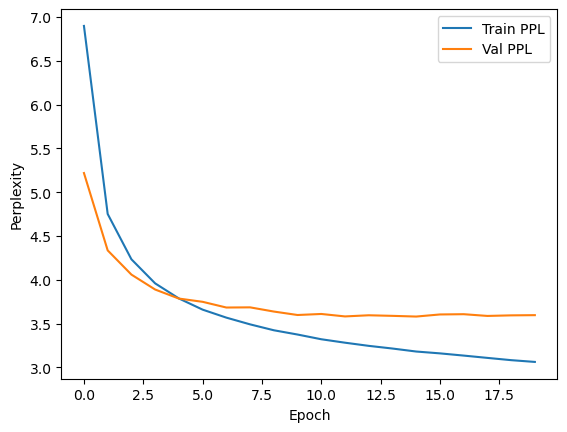

In [25]:
import matplotlib.pyplot as plt

plt.plot(history["train_ppl"], label="Train PPL")
plt.plot(history["val_ppl"], label="Val PPL")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.legend()
plt.show()



### Predicción del próximo caracter

In [26]:
# funcionalidades para hacer encoding y decoding
def encode(text,max_length=max_context_size):
    # Encodeamos
    encoded = [char2idx[ch] for ch in text.lower()]
    # Si tienen distinto largo
    if len(encoded) < max_length: # Hago padding hasta max_len
        encoded = [0] * (max_length - len(encoded)) + encoded
    else: # O me quedo con los últimos max_len caracteres
        encoded = encoded[-max_length:]
   
    return encoded

def decode(idx):
    return idx2char[idx]

In [27]:
def predict_next_char(model, human_text, max_len, device="cpu"):
    model.eval()
    # Encodeamos
    encoded = encode(human_text,max_length=max_len)

    x = torch.as_tensor([encoded], dtype=torch.long, device=device)

    with torch.no_grad():
        y_hat = model.predict(x)  # (1, vocab_size+1)
        idx = y_hat.argmax().item()

        # Debemos buscar en el vocabulario el caracter
        # que corresponde al indice (y_hat) predicho por le modelo
        out_char = decode(idx)

    return out_char

In [28]:
predict_next_char(model, 'Godalmin', max_len=max_context_size, device=device)

'g'

### Generación de secuencias

In [29]:
def generate_seq_greedy(model, seed_text, max_length, n_chars, device="cpu"):
    """
        Exec model sequence prediction

        Args:
            model: modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_chars (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_chars" agregadas
    """
    output_text = seed_text
	# genero n_chars caracteres
    for _ in range(n_chars):
        c = predict_next_char(model, output_text, max_length, device=device)
		# Agrego el caracter a la frase predicha
        output_text += c
    return output_text

In [30]:
input_text='It was on the dark side of twilight when we got to b'
generate_seq_greedy(model, input_text, max_length=max_context_size, n_chars=30, device=device)

'It was on the dark side of twilight when we got to be all the same things and the '

In [38]:
input_text='that was arthur'
generate_seq_greedy(model, input_text, max_length=max_context_size, n_chars=15, device=device)

'that was arthur had been so so'

In [ ]:
input_text='la'
generate_seq_greedy(model, input_text, max_length=max_context_size, n_chars=30, device=device)

'late in the count in the strange things of the same '

In [68]:
input_text='near the correct'
generate_seq_greedy(model, input_text, max_length=max_context_size, n_chars=30, device=device)

'near the correct of the strange things of the '

###  Beam search y muestreo aleatorio

In [41]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []
  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1.,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)
    x = torch.as_tensor([encoded], dtype=torch.long, device=device)

    with torch.no_grad():
      # first prediction
      y_hat = model.predict(x).cpu()[0] # (1, vocab_size+1) => (vocab_size+1)

      # get vocabulary size
      vocab_size = y_hat.shape[0]

      # initialize history
      history_probs = [0]*num_beams
      history_tokens = [encoded]*num_beams # 10 beams, 100 (max_context_size)
      # select num_beams candidates
      history_probs, history_tokens = select_candidates([y_hat], num_beams, vocab_size, history_probs,
                                                        history_tokens, temp, mode)
      # beam search loop
      for i in range(num_words-1):

        preds = []

        for hist in history_tokens:

          # actualizar secuencia de tokens
          input_update = np.array([hist[i+1:]]).copy()
          # predicción
          x = torch.as_tensor(input_update, dtype=torch.long, device=device)
          y_hat = model.predict(x).cpu()[0] # (1, vocab_size+1) => (vocab_size+1)

          preds.append(y_hat)

        history_probs, history_tokens = select_candidates(preds, num_beams, vocab_size, history_probs, history_tokens, temp, mode)

    return history_tokens[:,-(len(input)+num_words):]

In [69]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=30,input="privilege to come", mode='det')
print(salidas[0])
print(''.join(decode(ch) for ch in salidas[0]))

[ 6 41 45 21 45 49 62 40 62 11 48 66 11 12 66 65 62  5 35 11 50 62 11 27
 23 45 68 43  9  9 11 60  4 66 24 11 65 24 27 48 11 50 23 21 62 11 48]
privilege to come.” he said:-- “you must have t


In [71]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=30,input="privilege to come", mode='sto', temp=1)
print(salidas[0])
print(''.join(decode(ch) for ch in salidas[0]))

[ 6 41 45 21 45 49 62 40 62 11 48 66 11 12 66 65 62 11 48 66 11 48 50 62
 11 49 23 48 48 62 41  2 11 23 64 68 11 45 11 59 64 66 19 11 48 50 23]
privilege to come to the latter, and i know tha


In [73]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=30,input="privilege to come", mode='sto', temp=0.5)
print(salidas[0])
print(''.join(decode(ch) for ch in salidas[0]))

[ 6 41 45 21 45 49 62 40 62 11 48 66 11 12 66 65 62 11 48 66 11 48 50 62
 11 19 45 64 68 66 19  2 11 23 64 68 11 48 50 62 41 62 11 45 27 11 64]
privilege to come to the window, and there is n


In [75]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=30,input="privilege to come", mode='sto', temp=0.2)
print(salidas[0])
print(''.join(decode(ch) for ch in salidas[0]))

[ 6 41 45 21 45 49 62 40 62 11 48 66 11 12 66 65 62 11 48 66 11 48 50 62
 11 12 66 24 64 48  2 11 23 64 68 11 48 50 62 11 12 66 24 64 48 11 45]
privilege to come to the count, and the count i


In [39]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=30,input="but only to know", mode='det')
print(salidas[0])
print(''.join(decode(ch) for ch in salidas[0]))

[37 24 48 11 66 64 49  4 11 48 66 11 59 64 66 19 11 48 50 23 48 11  4 66
 24 11 50 23 21 62 11 37 62 62 64 11 27 66 65 62 48 50 45 64 40 11]
but only to know that you have been something 


In [40]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=30,input="that we are in for a storm", mode='sto', temp=0.5)
print(salidas[0])
print(''.join(decode(ch) for ch in salidas[0]))

[48 50 23 48 11 19 62 11 23 41 62 11 45 64 11 26 66 41 11 23 11 27 48 66
 41 65  2 11 23 64 68 11 48 50 62 41 62 11 45 27 11 64 66 11 27 66 24 64
 68 11 48 50 23 48 11 45]
that we are in for a storm, and there is no sound that i


### Conclusiones

En la prueba greedy, el modelo de predicción de caracteres termina armando palabras que parecen tener sentido, no tanto asi las oraciones que forma.  
En ocasiones, cuando se pide una cantidad de caracteres elevadas, parece entrar en un circulo donde se repiten los caracteres.  
También da la sensación de que tiene letras y secuencias que se repiten más. (ej. las secuencias strange, things y so aparecieron muchas veces)

En las pruebas beam search, tanto en determinístico como en estocástico los caracteres formaron palabras existentes, igual que en el caso anterior, el sentido de la oración puede no ser del todo bueno.  
En el estocástico, con una temperatura alta hay más variedad de resultados, al bajar la temperatura, los resultados que ofrece se repiten, incluso en la temperatura más baja, solo ofrece un par de resultados distintos.  
También parece que hay secuencias de caracteres que tiende a devolver con mayor frecuencia.

Es destacable que no vimos casi palabras desconocidas, aunque en el primer ejemplo determinístico, devolvió varios simbolos como predicciones, algunos que podrían ser correctos, otros que no tanto.